In [1]:
import pandas as pd
import numpy as np
import scipy

In [2]:
# Definde function of R-Squared score:

def r_squared(y_pred, y_actual):
    
    import numpy as np
    ss_tot = np.sum((y_actual-np.mean(y_actual))**2)
    ss_res = np.sum((y_pred-y_actual)**2)
    
    return 1-ss_res/ss_tot

In [3]:
# Read in data and filter ontario cases:

df = pd.read_csv('cases.csv')
df_on = df[df['province'] == 'Ontario']
on_cases = df_on[['date_report']].reset_index(drop = True)
on_cases['cases'] = on_cases.index+1
on_cases['date'] = on_cases['date_report'].apply(pd.to_datetime)
on_day_summary = on_cases.groupby(by = 'date').apply(lambda x: pd.Series({'cases': x['cases'].max()})).reset_index()
on_day_summary.head()

,date,cases
0,2020-01-25,1
1,2020-01-27,2
2,2020-01-31,3
3,2020-02-23,4
4,2020-02-26,5


In [4]:
# Create data frame that only has columns of date, cases numbers, and day number:

df_dates = pd.DataFrame({'date': pd.date_range(start='1/25/2020', periods = 66)})
df_final = pd.merge_asof(df_dates, on_day_summary, on = 'date', direction = 'forward')
df_final['day'] = df_final.index + 1
df_final.head()

,date,cases,day
0,2020-01-25,1,1
1,2020-01-26,2,2
2,2020-01-27,2,3
3,2020-01-28,3,4
4,2020-01-29,3,5


Text(0.5, 1.0, 'Ontario Cases Growth by Day')

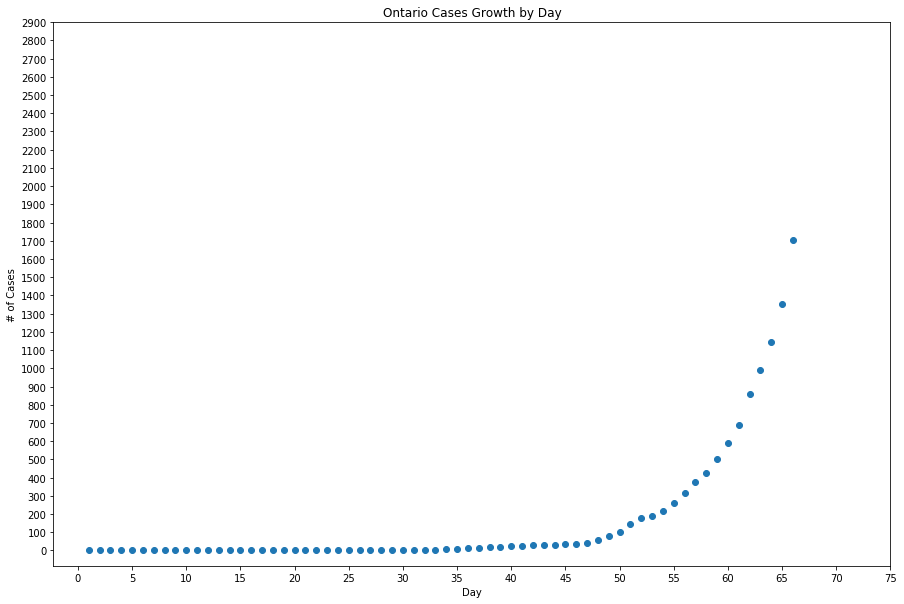

In [5]:
# Plot day and case counts:

import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_final)
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 80, 5))
plt.yticks(range(0, 3000, 100))
plt.title('Ontario Cases Growth by Day')

Text(0.5, 1.0, 'Day vs. Logarithm of Cases')

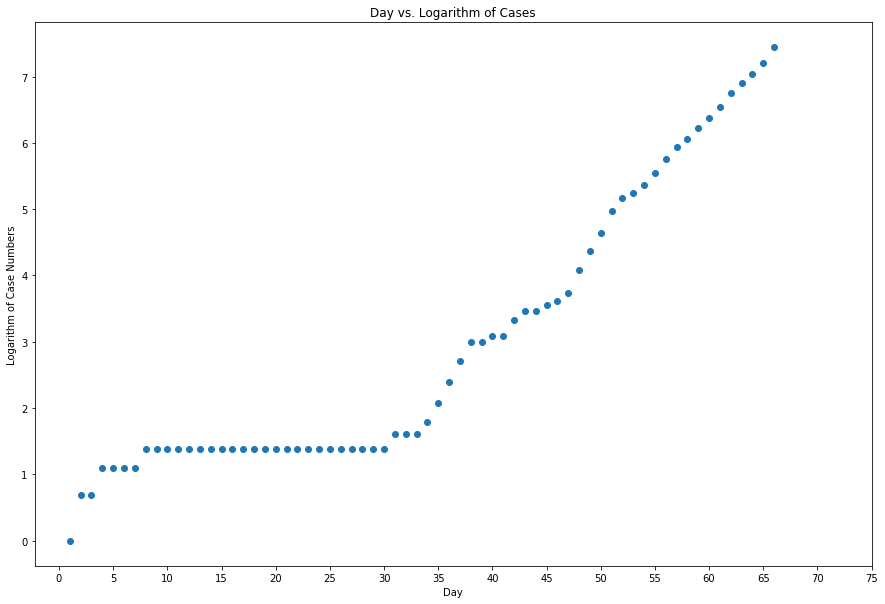

In [6]:
# From plot above number of cases seems to be exponentially increasing.
# Plot scatter plot of day and logarithm of case counts:

df_final['ln_y'] = np.log(df_final['cases'])
plt.figure(figsize=(15,10))
plt.scatter('day', 'ln_y', data = df_final)
plt.xlabel('Day')
plt.xticks(range(0, 80, 5))
plt.ylabel('Logarithm of Case Numbers')
plt.title('Day vs. Logarithm of Cases')

In [7]:
# By looking at the plot above, cases start increase exponentially at around day 35.
# Fit an exponential model on cases after day 35, with new day starting day 35 as day 1:

df_exp = df_final[df_final['day'] >= 35].reset_index(drop = True)
df_exp['new_day'] = df_exp.index + 1

from sklearn.linear_model import LinearRegression
x = df_exp[['new_day']]
y = df_exp[['ln_y']]

reg = LinearRegression().fit(x, y)
df_exp['ln_pred'] = reg.predict(x)
df_exp['pred'] = np.exp(df_exp['ln_pred'])

R-Squared score of exponential model: 0.9969221989139209


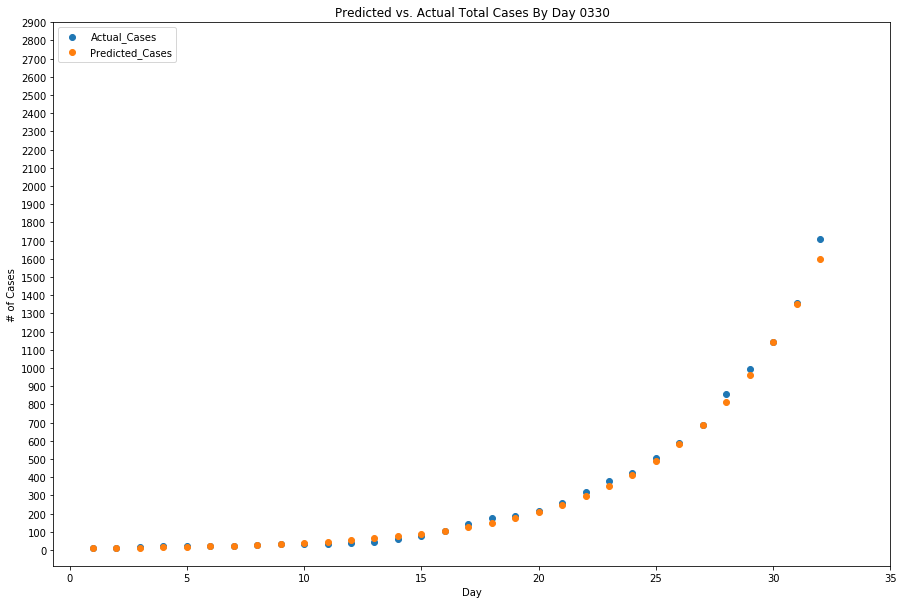

In [8]:
# Plot the fit and calculate R-Squared score:

plt.figure(figsize=(15,10))
plt.scatter('new_day', 'cases', data = df_exp, label = 'Actual_Cases')
plt.scatter('new_day', 'pred', data = df_exp, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 40, 5))
plt.yticks(range(0, 3000, 100))
plt.title('Predicted vs. Actual Total Cases By Day 0330')
plt.legend(loc = 2)

print('R-Squared score of exponential model:',r_squared(df_exp['pred'], df_exp['cases']))

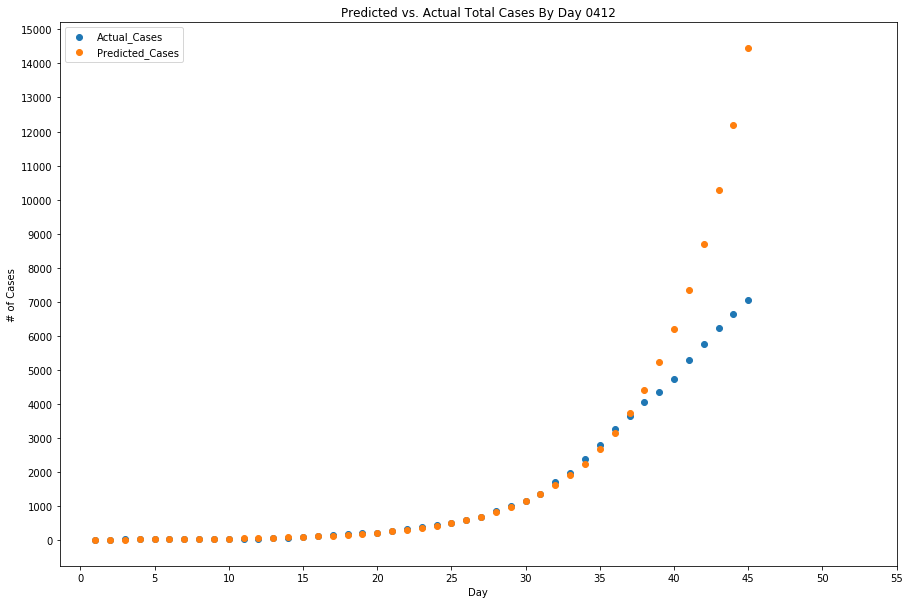

In [9]:
# Fit the data until 04/12/2020 using the exponential model above.
# Plot prediction until 04/12/2020:

df_0412 = pd.read_excel('predictions.xlsx', sheet_name = 'cases_0412')
df_0412['ln_pred'] = reg.predict(df_0412[['day']])
df_0412['pred'] = np.exp(df_0412['ln_pred'])

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_0412, label = 'Actual_Cases')
plt.scatter('day', 'pred', data = df_0412, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 60, 5))
plt.yticks(range(0, 16000, 1000))
plt.title('Predicted vs. Actual Total Cases By Day 0412')
plt.legend(loc = 2)

C:\Users\Matt\Anaconda3\envs\streamlit1\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


R-Squared score of logistic griwth model - cases until 04/12/2020: 0.9993632580111936


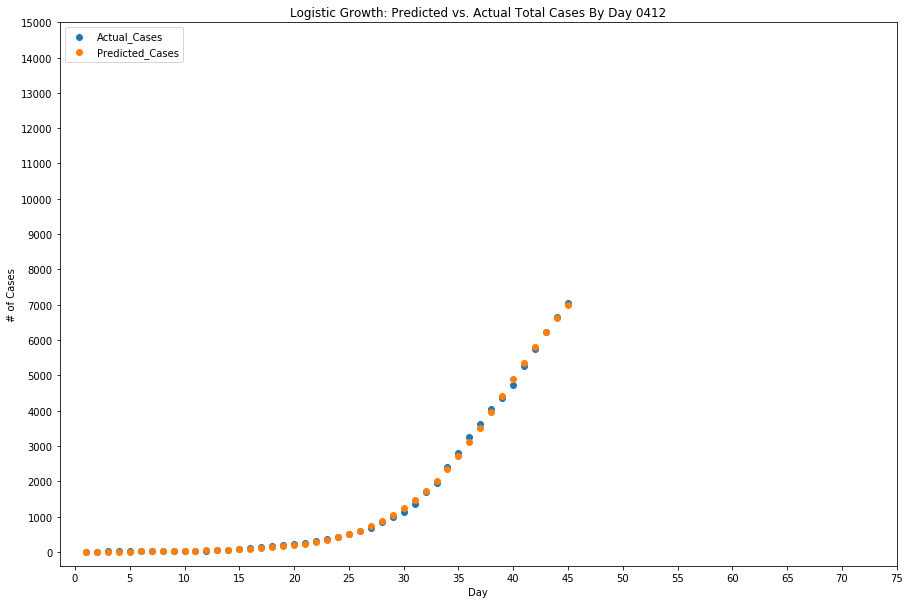

In [10]:
# Actually we can see that the growth rate of new cases is decreasing. So exponential growthe model wil not fit.
# Try fitting a logistic growth model and calculate R-Squared score:

def logistic_growth_0412(x, a0, b0, c0):
    return c0/(1+a0*np.exp(-b0*x))

import scipy.optimize as optim
x_log_0412 = df_0412['day']
y_log_0412 = df_0412['cases']
p0 = np.random.exponential(size = 3)
(a0,b0,c0), cov0 = optim.curve_fit(logistic_growth_0412, x_log_0412, y_log_0412, p0 = p0, maxfev = 20000)
df_0412['logistic_growth_pred'] = logistic_growth_0412(x_log_0412, a0, b0, c0)

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_0412, label = 'Actual_Cases')
plt.scatter('day', 'logistic_growth_pred', data = df_0412, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 80, 5))
plt.yticks(range(0, 16000, 1000))
plt.title('Logistic Growth: Predicted vs. Actual Total Cases By Day 0412')
plt.legend(loc = 2)

print('R-Squared score of logistic griwth model - cases until 04/12/2020:',r_squared(df_0412['logistic_growth_pred'], \
                                                                                     df_0412['cases']))


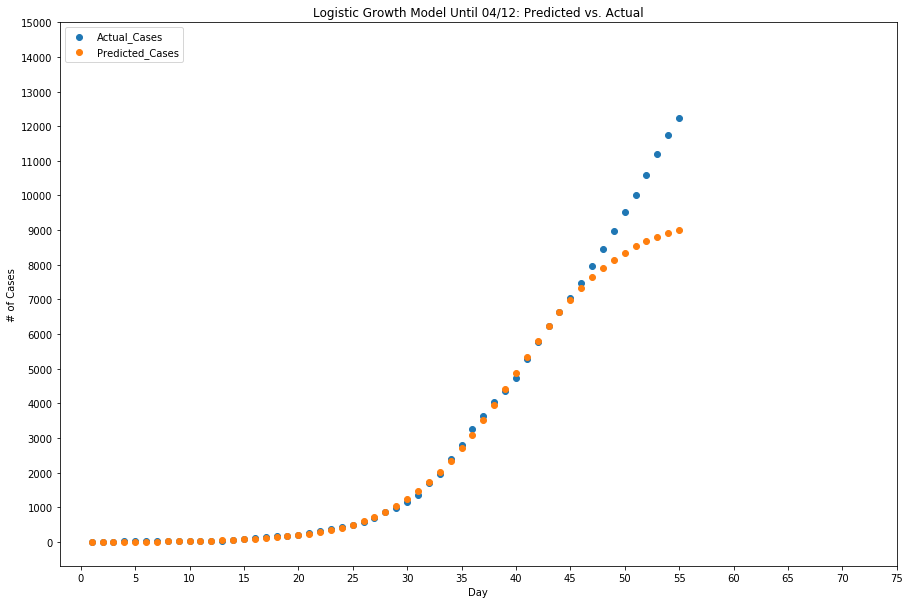

In [11]:
# Predict cases until 04/22/2020 using model created on cases until 04/12/2020:

df_0422_pred = pd.read_excel('predictions.xlsx', sheet_name = 'cases_0422')
df_0422_pred['logistic_growth_pred'] = logistic_growth_0412(df_0422_pred['day'], a0, b0, c0)

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_0422_pred, label = 'Actual_Cases')
plt.scatter('day', 'logistic_growth_pred', data = df_0422_pred, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 80, 5))
plt.yticks(range(0, 16000, 1000))
plt.title('Logistic Growth Model Until 04/12: Predicted vs. Actual')
plt.legend(loc = 2)

R-Squared score of logistic griwth model - cases until 04/22/2020: 0.9978140120631114


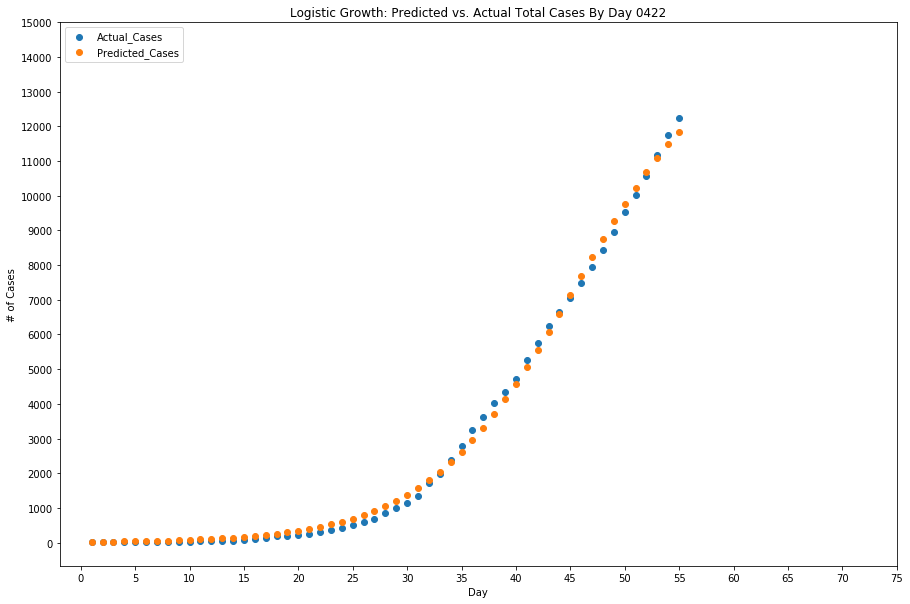

In [12]:
# From the plot above it seems the model using data until 04/12 does not fit the data afterwards well.
# Create a new logistic growth model using data updated as of 04/22 and calculate R-Squared score:

df_0422 = pd.read_excel('predictions.xlsx', sheet_name = 'cases_0422')
def logistic_growth_0422(x, a1, b1, c1):
    return c1/(1+a1*np.exp(-b1*x))

import scipy.optimize as optim
x_log_0422 = df_0422['day']
y_log_0422 = df_0422['cases']
p0 = np.random.exponential(size = 3)
(a1,b1,c1), cov1 = optim.curve_fit(logistic_growth_0422, x_log_0422, y_log_0422, p0 = p0, maxfev = 20000)
df_0422['logistic_growth_pred'] = logistic_growth_0422(x_log_0422, a1, b1, c1)

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_0422, label = 'Actual_Cases')
plt.scatter('day', 'logistic_growth_pred', data = df_0422, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 80, 5))
plt.yticks(range(0, 16000, 1000))
plt.title('Logistic Growth: Predicted vs. Actual Total Cases By Day 0422')
plt.legend(loc = 2)

print('R-Squared score of logistic griwth model - cases until 04/22/2020:',r_squared(df_0422['logistic_growth_pred'], \
                                                                                     df_0422['cases']))

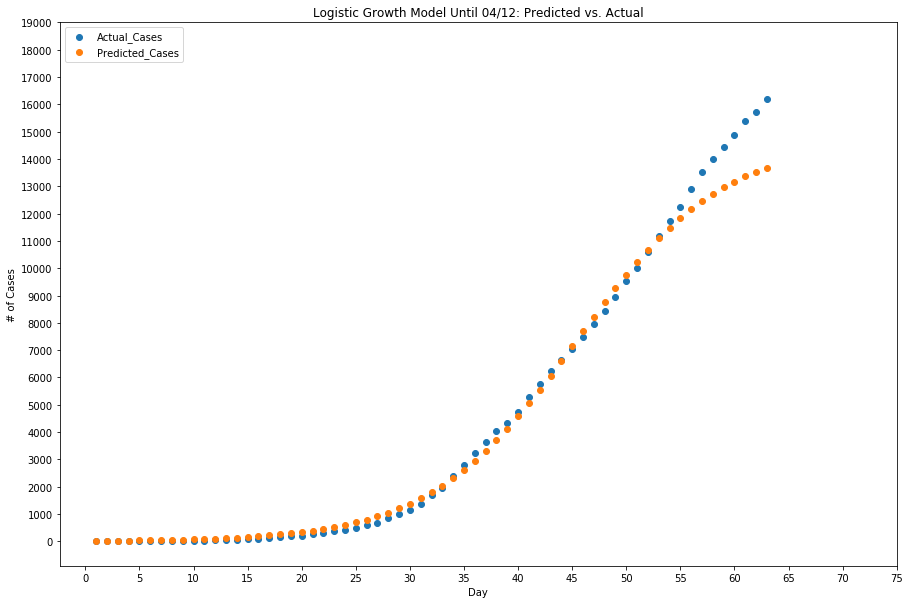

In [13]:
# Predict cases until 04/30/2020 using model created on cases until 04/22/2020:

df_0430_pred = pd.read_excel('predictions.xlsx', sheet_name = 'cases_0430')
df_0430_pred['logistic_growth_pred'] = logistic_growth_0422(df_0430_pred['day'], a1, b1, c1)

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_0430_pred, label = 'Actual_Cases')
plt.scatter('day', 'logistic_growth_pred', data = df_0430_pred, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 80, 5))
plt.yticks(range(0, 20000, 1000))
plt.title('Logistic Growth Model Until 04/12: Predicted vs. Actual')
plt.legend(loc = 2)

R-Squared score of generalized logistic griwth model - cases until 04/30/2020: 0.9990680924175174


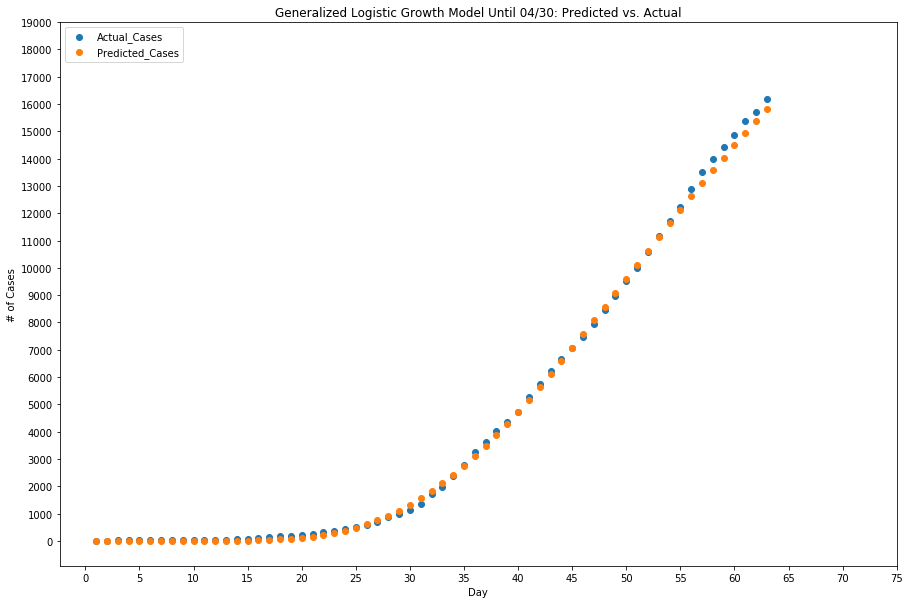

In [14]:
# We can see that the updated logistic growth model still does not predict number of cases well after 04/22.
# Try fitting a generalized logistic growth model on data of 04/22/2020 and predict cases until 04/30/2020:

def generalized_logistic_growth(x, l, a, b, c):
    return l*((1+(a-1)*np.exp(-b*(x-c)))**(1/(1-a)))

import scipy.optimize as optim
x_log_0422 = df_0422['day']
y_log_0422 = df_0422['cases']
p0 = (25000, 0.9, 0.05, 40)
(l, a, b, c), cov = optim.curve_fit(generalized_logistic_growth, x_log_0422, y_log_0422, p0 = p0, maxfev = 40000)
                     
df_0430_pred = pd.read_excel('predictions.xlsx', sheet_name = 'cases_0430')
df_0430_pred['logistic_growth_pred'] = generalized_logistic_growth(df_0430_pred['day'], l, a, b, c)

plt.figure(figsize=(15,10))
plt.scatter('day', 'cases', data = df_0430_pred, label = 'Actual_Cases')
plt.scatter('day', 'logistic_growth_pred', data = df_0430_pred, label = 'Predicted_Cases')
plt.xlabel('Day')
plt.ylabel('# of Cases')
plt.xticks(range(0, 80, 5))
plt.yticks(range(0, 20000, 1000))
plt.title('Generalized Logistic Growth Model Until 04/30: Predicted vs. Actual')
plt.legend(loc = 2)

print('R-Squared score of generalized logistic griwth model - cases until 04/30/2020:',\
      r_squared(df_0430_pred['logistic_growth_pred'], df_0430_pred['cases']))

In [15]:
import streamlit as st
!jupyter nbconvert   --to script ontario_case_predictions.ipynb
!awk '!/ipython/' ontario_case_predictions.py >  temp.py && mv temp.py app.py && rm ontario_case_predictions.py
!streamlit run ontario_case_predictions.py

[NbConvertApp] Converting notebook ontario_case_predictions.ipynb to script
[NbConvertApp] Writing 8875 bytes to ontario_case_predictions.py
'awk' is not recognized as an internal or external command,
operable program or batch file.


^C


In [17]:
st.pyplot()

NameError: name 'figure' is not defined